In [80]:
from pathlib import Path
from os.path import dirname, realpath
from datetime import datetime
import os
import shutil
import psutil
from typing import List, Union
from pycaret.anomaly import *
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# import LSTM libraries
from sklearn.preprocessing import MinMaxScaler, StandardScaler
sns.set(color_codes=True)
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers
#import BIRCH libraries
from sklearn.cluster import Birch
from sklearn import preprocessing
from scipy.spatial import distance

In [51]:
SYSTEM = 'sockshop'
# SYSTEM = 'trainticket'
# Define the main directory
TRAINING_DATA_FOLDER = Path(f"../../vuDevOps/data_collection/{SYSTEM}-training-data")
DATA_FOLDER = Path(f"../../vuDevOps/data_collection/{SYSTEM}-data/")

RESULTS_FOLDER = Path(f"../../experiment_results/{SYSTEM}-data")

AD_FOLDER = Path("../AD")
AD_MODELS = ["iforest", "svm", "lof", "knn"]

# SAVED_AD_MODELS_PATH = os.path.join(AD_FOLDER,"anomaly_detection_models")
# LOCAL_AD_MODELS = os.path.join(SAVED_AD_MODELS_PATH,SYSTEM)

In [52]:
def load_metrics(base_dir):
    data = []
    file_count = 0
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith("metrics.csv"):
                file_path = os.path.join(root, file)
                # print(f"Processing file: {file_path}")
                df = pd.read_csv(file_path)
                # Extract metadata from the file path
                parts = file_path.split(os.sep)
                scenario = parts[5]
                behavior = parts[6]
                if behavior == 'anomalous':
                    service = parts[7]
                    users = parts[8]
                    repetition = parts[9]
                else:
                    service = 'normal'
                    users = parts[7]
                    repetition = parts[8]
                
                df['scenario'] = scenario
                df['behavior'] = behavior
                df['service'] = service
                df['users'] = users
                df['repetition'] = repetition
                data.append(df)
                file_count += 1
    print(f"Total files loaded: {file_count}")
    return pd.concat(data, ignore_index=True)


In [53]:
data = load_metrics(DATA_FOLDER)
# data.to_csv("combined.csv", index=False)
data

Total files loaded: 360


,time,carts_cpu,carts-db_cpu,catalogue_cpu,catalogue-db_cpu,front-end_cpu,orders_cpu,orders-db_cpu,payment_cpu,queue-master_cpu,...,user_power,user-db_power,scenario,behavior,service,users,repetition,orders_disk,catalogue_disk,queue-master_disk
0,1.720475e+09,0.039099,0.007015,0.003332,0.001180,0.030832,0.004786,0.005776,0.001558,0.004410,...,0.000874,0.000811,scenario_A,anomalous,front-end,100,repetition_1,NaN,NaN,NaN
1,1.720475e+09,0.059431,0.007996,0.005746,0.003404,0.101100,0.004943,0.005963,0.001533,0.004416,...,0.001258,0.000843,scenario_A,anomalous,front-end,100,repetition_1,NaN,NaN,NaN
2,1.720475e+09,0.065530,0.008247,0.008679,0.005220,0.342384,0.005026,0.005949,0.001326,0.004698,...,0.001460,0.001042,scenario_A,anomalous,front-end,100,repetition_1,NaN,NaN,NaN
3,1.720475e+09,0.077802,0.008251,0.012895,0.009201,0.573051,0.005198,0.006108,0.001483,0.004779,...,0.001629,0.001053,scenario_A,anomalous,front-end,100,repetition_1,NaN,NaN,NaN
4,1.720475e+09,0.085144,0.008638,0.014121,0.010104,0.831620,0.005141,0.005942,0.001470,0.004675,...,0.001735,0.000984,scenario_A,anomalous,front-end,100,repetition_1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21875,1.720430e+09,2.828884,1.960483,0.606384,0.356611,1.109236,0.399870,0.004384,0.022462,0.003844,...,0.135037,0.055955,scenario_B,baseline,normal,1000,repetition_9,NaN,NaN,NaN
21876,1.720430e+09,2.830664,1.851019,0.598874,0.356424,1.109167,0.396980,0.004374,0.022409,0.003727,...,0.118310,0.048866,scenario_B,baseline,normal,1000,repetition_9,NaN,NaN,NaN
21877,1.720430e+09,2.843181,1.951623,0.567690,0.358015,1.108863,0.399207,0.004350,0.022597,0.003826,...,0.118387,0.048518,scenario_B,baseline,normal,1000,repetition_9,NaN,NaN,NaN
21878,1.720430e+09,2.695615,1.963901,0.605374,0.357926,1.108358,0.368062,0.004400,0.022720,0.003611,...,0.118045,0.048746,scenario_B,baseline,normal,1000,repetition_9,NaN,NaN,NaN


In [7]:
# Check for missing values
missing_values = data.isnull().sum()
print("Missing values in each column:")
print(missing_values)

# Expected combinations
scenarios = ['scenario_A', 'scenario_B']
behaviors = ['anomalous', 'baseline']
services_anomalous = ['front-end', 'orders']
services_normal = ['normal']
users = ['100', '1000']
repetitions = [f'repetition_{i}' for i in range(1, 31)]

from itertools import product

expected_combinations = []

# Generate expected combinations for anomalous behavior
expected_combinations += list(product(scenarios, behaviors[0], services_anomalous, users, repetitions))

# Generate expected combinations for normal behavior
expected_combinations += list(product(scenarios, behaviors[1], services_normal, users, repetitions))

expected_count = len(expected_combinations)
print(f"Expected number of combinations (including repetitions): {expected_count}")

# Check if all expected combinations are present
grouped = data.groupby(['scenario', 'behavior', 'service', 'users', 'repetition']).size().reset_index(name='counts')
missing_combinations = [comb for comb in expected_combinations if not grouped[(grouped['scenario'] == comb[0]) & 
                                                                              (grouped['behavior'] == comb[1]) & 
                                                                              (grouped['service'] == comb[2]) & 
                                                                              (grouped['users'] == comb[3]) & 
                                                                              (grouped['repetition'] == comb[4])].empty]
print(f"Number of missing combinations: {len(missing_combinations)}")
if missing_combinations:
    print("Missing combinations:")
    for comb in missing_combinations:
        print(comb)


Missing values in each column:
time                                  0
rabbitmq_cpu                         61
redis_cpu                             0
ts-account-mongo_cpu                  0
ts-admin-basic-info-service_cpu       0
                                   ... 
repetition                            0
ts-avatar-service_disk             4920
ts-price-service_disk              7138
redis_disk                         7137
ts-ticket-office-service_disk      7138
Length: 382, dtype: int64
Expected number of combinations (including repetitions): 3120
Number of missing combinations: 0


In [54]:
def convert_data(data):
    # Convert UNIX timestamp to datetime
    data['time'] = pd.to_datetime(data['time'], unit='s')

    # Calculate time intervals
    data['time_intervals'] = data['time'].diff().dt.total_seconds().abs()
    data['time_intervals'].fillna(method="bfill", inplace=True)
    # Set the default time interval to 5 seconds where the interval is greater than 5 minutes (300s)
    data['time_intervals'] = data['time_intervals'].apply(lambda x: 5.0 if x > 300.0 else x)
    time_interval = data['time_intervals'].iloc[0]

    # Convert CPU usage to percentage
    cpu_columns = [col for col in data.columns if '_cpu' in col]
    data[cpu_columns] = data[cpu_columns] * 100

    # Calculate energy consumption from power consumption
    power_columns = [col for col in data.columns if '_power' in col]
    for col in power_columns:
        new_col_name = f"{col.split('_')[0]}_energy"
        data[new_col_name] = data[col] * data['time_intervals']

    return data, time_interval


In [55]:
converted_data, time_interval = convert_data(data)
# converted_data.to_csv("ts-converted.csv", index=False)
converted_data

,time,carts_cpu,carts-db_cpu,catalogue_cpu,catalogue-db_cpu,front-end_cpu,orders_cpu,orders-db_cpu,payment_cpu,queue-master_cpu,...,catalogue-db_energy,front-end_energy,orders_energy,orders-db_energy,payment_energy,queue-master_energy,rabbitmq_energy,shipping_energy,user_energy,user-db_energy
0,2024-07-08 21:43:32.880000000,3.909938,0.701511,0.333210,0.118047,3.083235,0.478595,0.577600,0.155781,0.440987,...,0.001844,0.016504,0.002839,0.004281,0.001545,0.003656,0.043678,0.003067,0.004372,0.004056
1,2024-07-08 21:43:37.880000000,5.943064,0.799610,0.574647,0.340371,10.110014,0.494281,0.596341,0.153291,0.441592,...,0.004322,0.029235,0.002616,0.004279,0.001558,0.004096,0.048194,0.003035,0.006289,0.004216
2,2024-07-08 21:43:42.880000000,6.553001,0.824666,0.867875,0.521957,34.238394,0.502579,0.594899,0.132631,0.469831,...,0.006080,0.781617,0.003525,0.004414,0.001355,0.004663,0.043528,0.004059,0.007302,0.005208
3,2024-07-08 21:43:47.880000000,7.780177,0.825145,1.289529,0.920083,57.305106,0.519755,0.610767,0.148296,0.477862,...,0.006264,0.932239,0.004039,0.004940,0.001725,0.004911,0.060003,0.003872,0.008147,0.005267
4,2024-07-08 21:43:52.880000000,8.514415,0.863842,1.412086,1.010366,83.161989,0.514145,0.594157,0.147050,0.467543,...,0.012040,0.906505,0.004305,0.005032,0.001615,0.011572,0.066331,0.004415,0.008675,0.004919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21875,2024-07-08 09:13:19.155000064,282.888440,196.048297,60.638431,35.661088,110.923635,39.986962,0.438411,2.246191,0.384438,...,0.685875,1.868230,0.689311,0.007574,0.032990,0.006629,0.082420,0.008943,0.675185,0.279775
21876,2024-07-08 09:13:24.155000064,283.066357,185.101902,59.887371,35.642368,110.916686,39.697974,0.437374,2.240917,0.372661,...,0.689752,1.616175,0.696605,0.007563,0.033481,0.006637,0.081036,0.009422,0.591551,0.244328
21877,2024-07-08 09:13:29.155000064,284.318124,195.162284,56.768995,35.801547,110.886326,39.920736,0.434970,2.259700,0.382577,...,0.688466,1.854592,0.695881,0.007063,0.033696,0.007076,0.090197,0.009861,0.591934,0.242590
21878,2024-07-08 09:13:34.155000064,269.561514,196.390095,60.537414,35.792597,110.835781,36.806172,0.439974,2.271994,0.361098,...,0.617657,1.632194,0.670419,0.007567,0.033122,0.007118,0.082957,0.009895,0.590224,0.243729


In [56]:
normal_data = converted_data[converted_data['behavior'] == 'baseline']
# normal_data.to_csv("ts-normal_data.csv", index=False)
normal_data

,time,carts_cpu,carts-db_cpu,catalogue_cpu,catalogue-db_cpu,front-end_cpu,orders_cpu,orders-db_cpu,payment_cpu,queue-master_cpu,...,catalogue-db_energy,front-end_energy,orders_energy,orders-db_energy,payment_energy,queue-master_energy,rabbitmq_energy,shipping_energy,user_energy,user-db_energy
7290,2024-07-08 03:27:40.007000064,5.524825,0.756626,0.410524,0.215665,1.921555,0.422992,0.632167,0.204140,0.749739,...,0.001550,0.014698,0.003198,0.004781,0.001557,0.006095,0.052795,0.003580,0.003907,0.003511
7291,2024-07-08 03:27:45.007000064,6.120589,0.811001,0.706880,0.450183,3.428785,0.421309,0.631454,0.210171,0.513802,...,0.003151,0.021051,0.003275,0.004430,0.002229,0.005706,0.052499,0.003225,0.003579,0.003593
7292,2024-07-08 03:27:50.007000064,7.211458,0.837969,1.044362,0.742082,4.929865,0.422836,0.626239,0.180381,0.555476,...,0.003190,0.034412,0.003105,0.004502,0.002229,0.003394,0.062925,0.003258,0.003384,0.003862
7293,2024-07-08 03:27:55.007000064,8.402131,0.872682,1.278927,0.924910,6.206159,0.413455,0.634497,0.209215,0.546919,...,0.003306,0.040850,0.003155,0.004146,0.001909,0.003046,0.073103,0.003326,0.004332,0.003733
7294,2024-07-08 03:28:00.007000064,9.669644,0.940287,1.654980,1.140565,7.762513,0.417396,0.623491,0.206266,0.529209,...,0.005871,0.056871,0.003393,0.004184,0.002089,0.003285,0.065240,0.003153,0.005192,0.003705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21875,2024-07-08 09:13:19.155000064,282.888440,196.048297,60.638431,35.661088,110.923635,39.986962,0.438411,2.246191,0.384438,...,0.685875,1.868230,0.689311,0.007574,0.032990,0.006629,0.082420,0.008943,0.675185,0.279775
21876,2024-07-08 09:13:24.155000064,283.066357,185.101902,59.887371,35.642368,110.916686,39.697974,0.437374,2.240917,0.372661,...,0.689752,1.616175,0.696605,0.007563,0.033481,0.006637,0.081036,0.009422,0.591551,0.244328
21877,2024-07-08 09:13:29.155000064,284.318124,195.162284,56.768995,35.801547,110.886326,39.920736,0.434970,2.259700,0.382577,...,0.688466,1.854592,0.695881,0.007063,0.033696,0.007076,0.090197,0.009861,0.591934,0.242590
21878,2024-07-08 09:13:34.155000064,269.561514,196.390095,60.537414,35.792597,110.835781,36.806172,0.439974,2.271994,0.361098,...,0.617657,1.632194,0.670419,0.007567,0.033122,0.007118,0.082957,0.009895,0.590224,0.243729


In [57]:
energy_columns = [col for col in normal_data.columns if 'energy' in col]
cpu_columns = [col for col in normal_data.columns if 'cpu' in col]
max_energy_value = converted_data[energy_columns].max().max()
max_cpu_value = converted_data[cpu_columns].max().max()
melted_data = normal_data.melt(id_vars=['users', 'scenario'], value_vars=energy_columns, var_name='service', value_name='energy_usage')

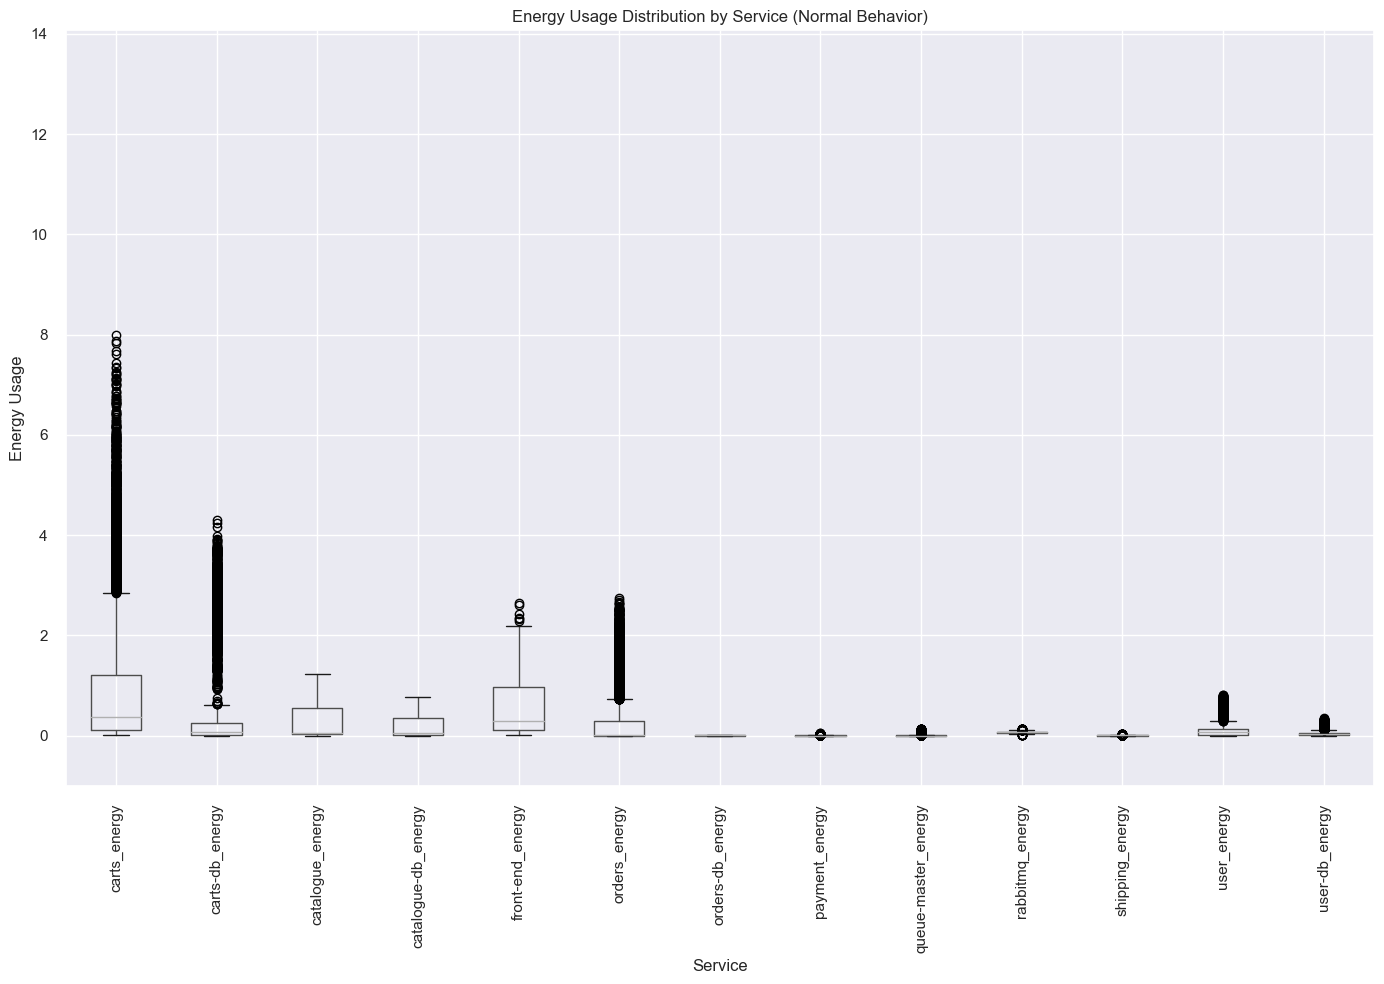

In [58]:
energy_columns = [col for col in normal_data.columns if 'energy' in col]
plt.figure(figsize=(14, 10))
normal_data[energy_columns].boxplot(rot=90)
# sns.boxplot(data=melted_data, x='service', y='energy_usage')
plt.title('Energy Usage Distribution by Service (Normal Behavior)')
plt.xlabel('Service')
plt.ylabel('Energy Usage')
plt.ylim(-1, max_energy_value)
plt.grid(True)
plt.tight_layout()
plt.show()

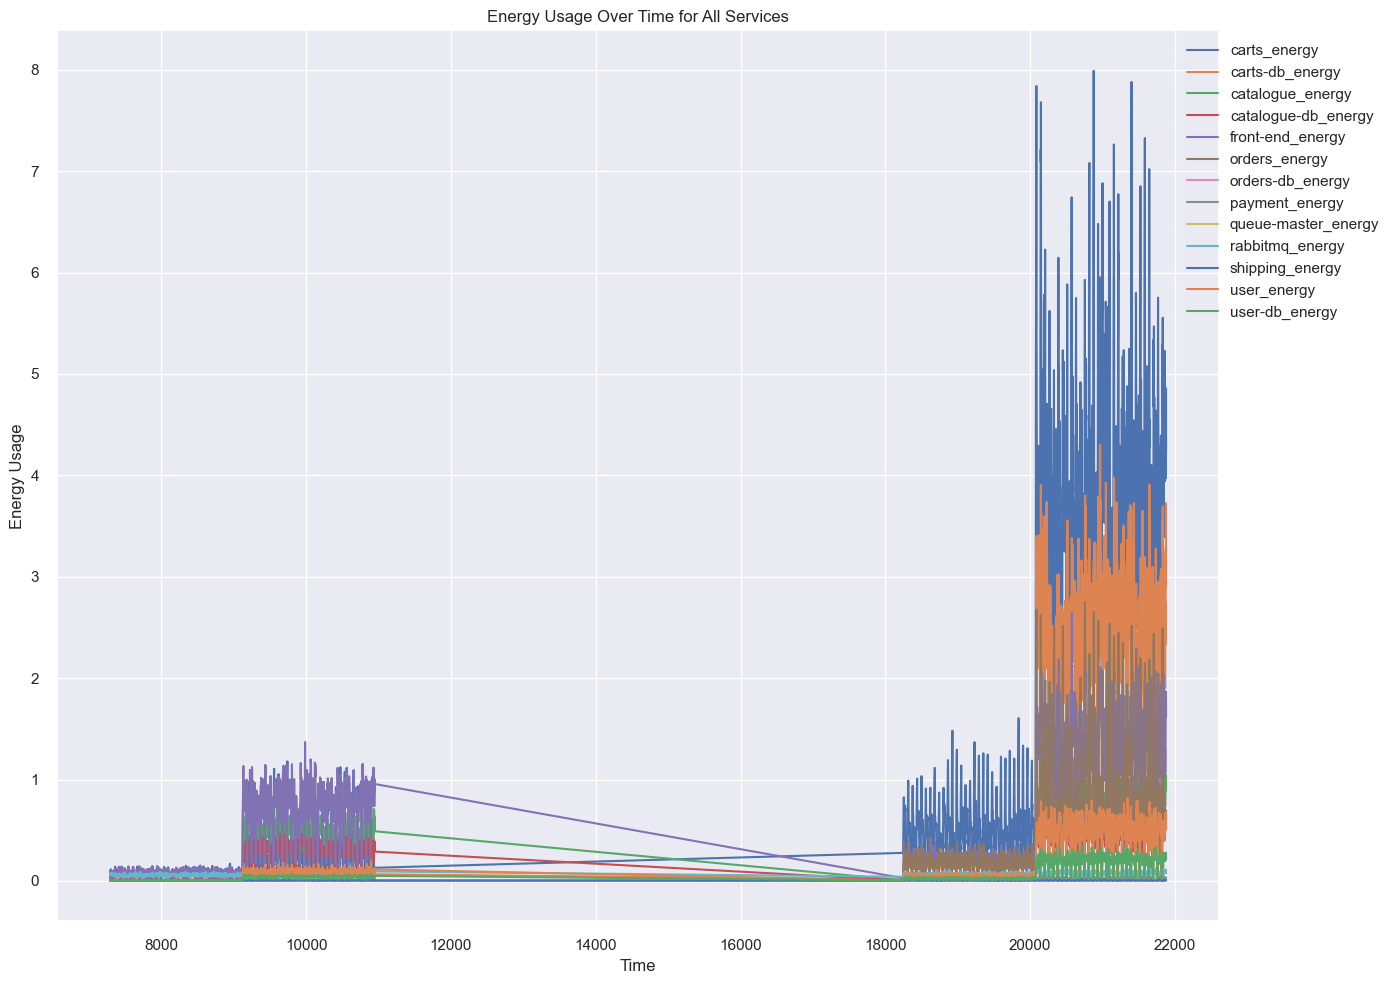

In [59]:
plt.figure(figsize=(14, 10))

for col in energy_columns:
    plt.plot(normal_data.index, normal_data[col], label=col)

plt.title('Energy Usage Over Time for All Services')
plt.xlabel('Time')
plt.ylabel('Energy Usage')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

In [60]:
low_user_load = normal_data[(normal_data['users'] == "100")]
melted_low = low_user_load.melt(id_vars='time', value_vars=energy_columns, var_name='service', value_name='energy_usage')
high_user_load = normal_data[(normal_data['users'] == "1000")]
melted_high = high_user_load.melt(id_vars='time', value_vars=energy_columns, var_name='service', value_name='energy_usage')

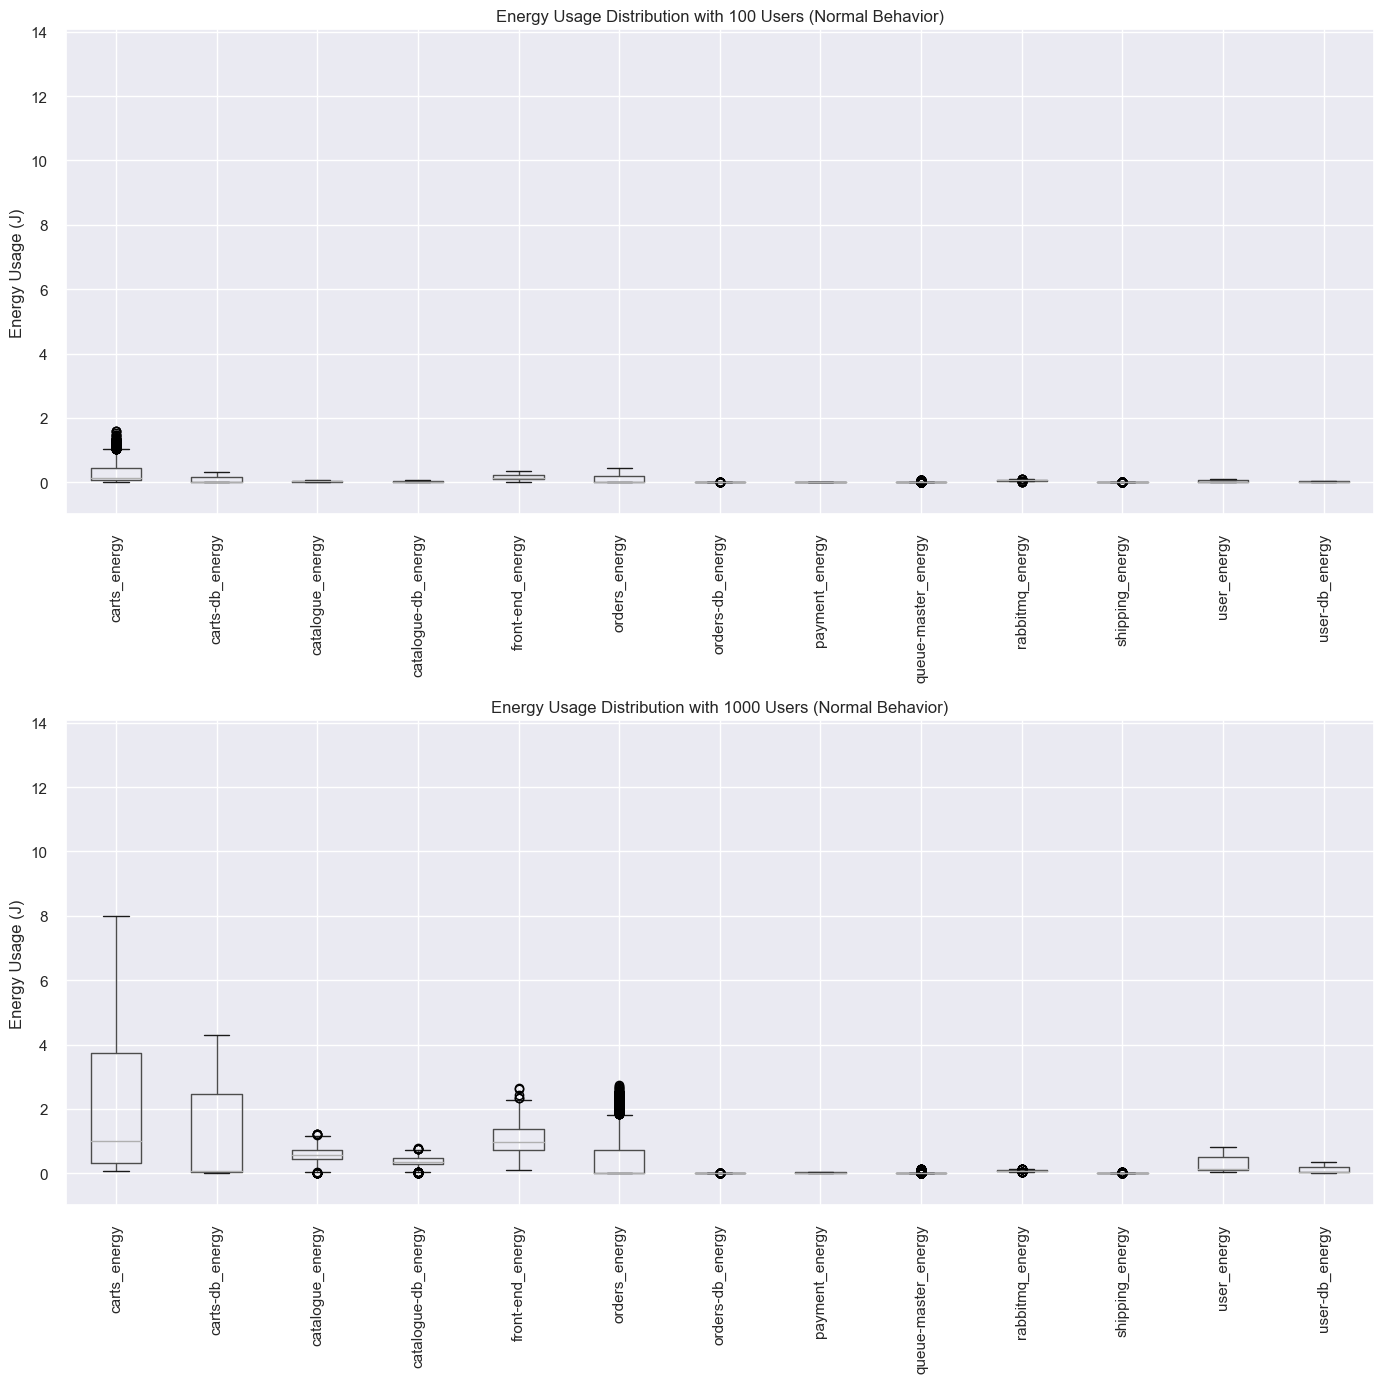

In [61]:
plt.figure(figsize=(14, 14))

plt.subplot(2, 1, 1)
low_user_load[energy_columns].boxplot(rot=90)
# sns.lineplot(x='time', y='energy_usage', hue='service', data=melted_low, palette='tab20')
# sns.boxplot(x='service', y='energy_usage', hue='users', data=melted_data)
plt.title('Energy Usage Distribution with 100 Users (Normal Behavior)')
# plt.title('CPU Usage Distribution with 100 Users (Normal Behavior)')
# plt.xlabel('Time')
plt.ylabel('Energy Usage (J)')
# plt.ylabel('CPU Usage')
plt.xticks(rotation=90)
plt.ylim(-1, max_energy_value)
# plt.ylim(-100, max_cpu_value)
# plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True)

plt.subplot(2, 1, 2)
high_user_load[energy_columns].boxplot(rot=90)
# sns.lineplot(x='time', y='energy_usage', hue='service', data=melted_high, palette='tab20')
plt.title('Energy Usage Distribution with 1000 Users (Normal Behavior)')
# plt.title('CPU Usage Distribution with 1000 Users (Normal Behavior)')
# plt.xlabel('Time')
plt.ylabel('Energy Usage (J)')
# plt.ylabel('CPU Usage')
plt.xticks(rotation=90)
plt.ylim(-1, max_energy_value)
# plt.ylim(-100, max_cpu_value)
# plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True)


plt.tight_layout()
plt.show()

In [62]:
scenario_a = normal_data[(normal_data['scenario'] == "scenario_A")]
melted_a = scenario_a.melt(id_vars='time', value_vars=energy_columns, var_name='service', value_name='energy_usage')
scenario_b = normal_data[(normal_data['scenario'] == "scenario_B")]
melted_b = scenario_b.melt(id_vars='time', value_vars=energy_columns, var_name='service', value_name='energy_usage')

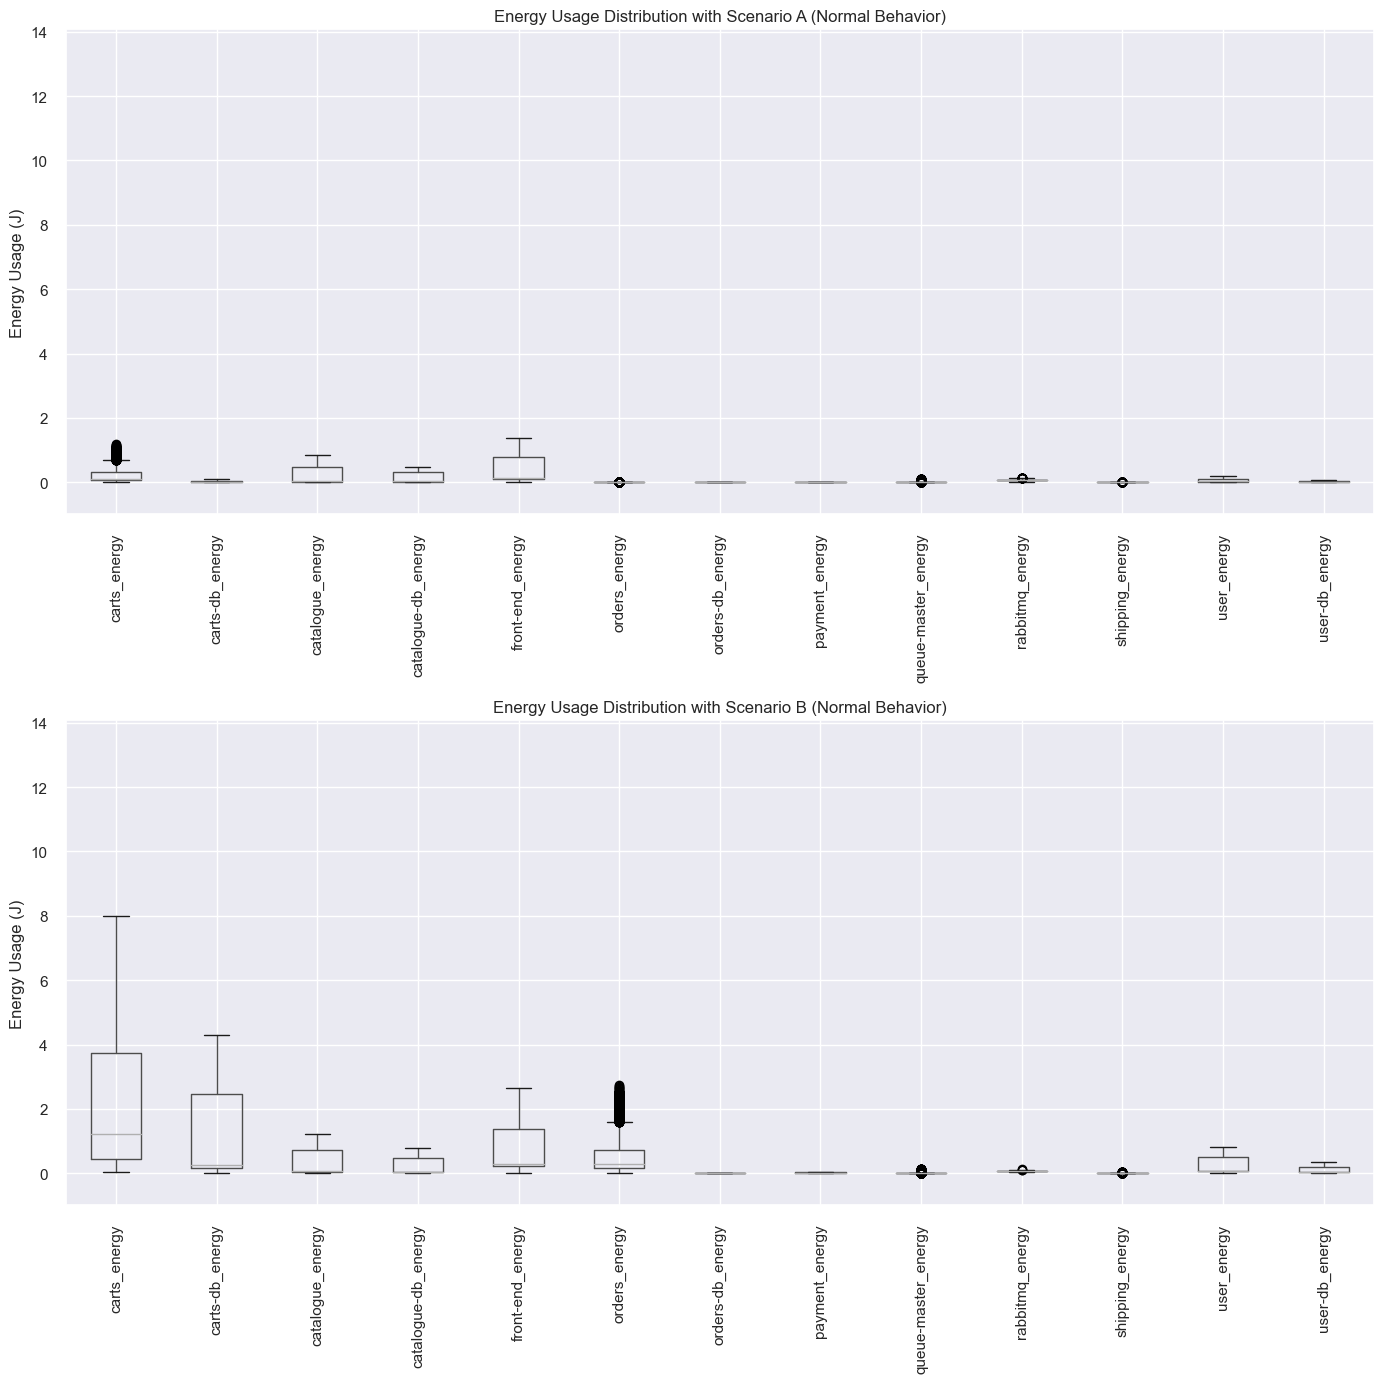

In [63]:
plt.figure(figsize=(14, 14))

plt.subplot(2, 1, 1)
# sns.lineplot(x='time', y='energy_usage', hue='service', data=melted_a, palette='tab20')
scenario_a[energy_columns].boxplot(rot=90)
# sns.boxplot(x='service', y='energy_usage', hue='scenario', data=melted_data)
plt.title('Energy Usage Distribution with Scenario A (Normal Behavior)')
# plt.title('CPU Usage Distribution with Scenario A (Normal Behavior)')
# plt.xlabel('Time')
plt.ylabel('Energy Usage (J)')
# plt.ylabel('CPU Usage')
plt.xticks(rotation=90)
plt.ylim(-1, max_energy_value)
# plt.ylim(-100, max_cpu_value)
# plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True)

plt.subplot(2, 1, 2)
# sns.lineplot(x='time', y='energy_usage', hue='service', data=melted_b, palette='tab20')
scenario_b[energy_columns].boxplot(rot=90)
plt.title('Energy Usage Distribution with Scenario B (Normal Behavior)')
# plt.title('CPU Usage Distribution with Scenario B (Normal Behavior)')
# plt.xlabel('Time')
plt.ylabel('Energy Usage (J)')
# plt.ylabel('CPU Usage')
plt.xticks(rotation=90)
plt.ylim(-1, max_energy_value)
# plt.ylim(-100, max_cpu_value)
# plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True)


plt.tight_layout()
plt.show()

In [64]:
anomalous_data = converted_data[converted_data['behavior'] == 'anomalous']
# anomalous_data.to_csv("anomalous_data.csv", index=False)
energy_columns = [col for col in anomalous_data.columns if 'energy' in col]
cpu_columns = [col for col in anomalous_data.columns if 'cpu' in col]
anomalous_data

,time,carts_cpu,carts-db_cpu,catalogue_cpu,catalogue-db_cpu,front-end_cpu,orders_cpu,orders-db_cpu,payment_cpu,queue-master_cpu,...,catalogue-db_energy,front-end_energy,orders_energy,orders-db_energy,payment_energy,queue-master_energy,rabbitmq_energy,shipping_energy,user_energy,user-db_energy
0,2024-07-08 21:43:32.880000000,3.909938,0.701511,0.333210,0.118047,3.083235,0.478595,0.577600,0.155781,0.440987,...,0.001844,0.016504,0.002839,0.004281,0.001545,0.003656,0.043678,0.003067,0.004372,0.004056
1,2024-07-08 21:43:37.880000000,5.943064,0.799610,0.574647,0.340371,10.110014,0.494281,0.596341,0.153291,0.441592,...,0.004322,0.029235,0.002616,0.004279,0.001558,0.004096,0.048194,0.003035,0.006289,0.004216
2,2024-07-08 21:43:42.880000000,6.553001,0.824666,0.867875,0.521957,34.238394,0.502579,0.594899,0.132631,0.469831,...,0.006080,0.781617,0.003525,0.004414,0.001355,0.004663,0.043528,0.004059,0.007302,0.005208
3,2024-07-08 21:43:47.880000000,7.780177,0.825145,1.289529,0.920083,57.305106,0.519755,0.610767,0.148296,0.477862,...,0.006264,0.932239,0.004039,0.004940,0.001725,0.004911,0.060003,0.003872,0.008147,0.005267
4,2024-07-08 21:43:52.880000000,8.514415,0.863842,1.412086,1.010366,83.161989,0.514145,0.594157,0.147050,0.467543,...,0.012040,0.906505,0.004305,0.005032,0.001615,0.011572,0.066331,0.004415,0.008675,0.004919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18241,2024-07-09 02:36:25.178999808,249.302095,174.862248,55.275629,33.715504,104.817404,326.664098,0.441529,2.138910,0.376722,...,0.562354,1.447609,5.716219,0.008704,0.025963,0.008673,0.097283,0.009753,0.712442,0.177089
18242,2024-07-09 02:36:30.178999808,250.030650,175.004762,55.368694,33.726463,104.060904,326.527247,0.428047,2.145905,0.382237,...,0.556434,1.435003,5.091082,0.008722,0.029784,0.009121,0.107296,0.009238,0.799713,0.215540
18243,2024-07-09 02:36:35.178999808,248.791706,173.703542,54.539590,33.469954,104.023963,326.524796,0.439502,2.135796,0.401155,...,0.557241,1.435375,5.014554,0.009264,0.025667,0.008686,0.094973,0.009768,0.706163,0.218023
18244,2024-07-09 02:36:40.178999808,247.124988,170.728146,54.415797,33.310798,103.411673,326.772292,0.425866,2.124247,0.339562,...,0.642472,1.161758,5.854557,0.009743,0.030360,0.009200,0.081718,0.009748,0.707178,0.218927


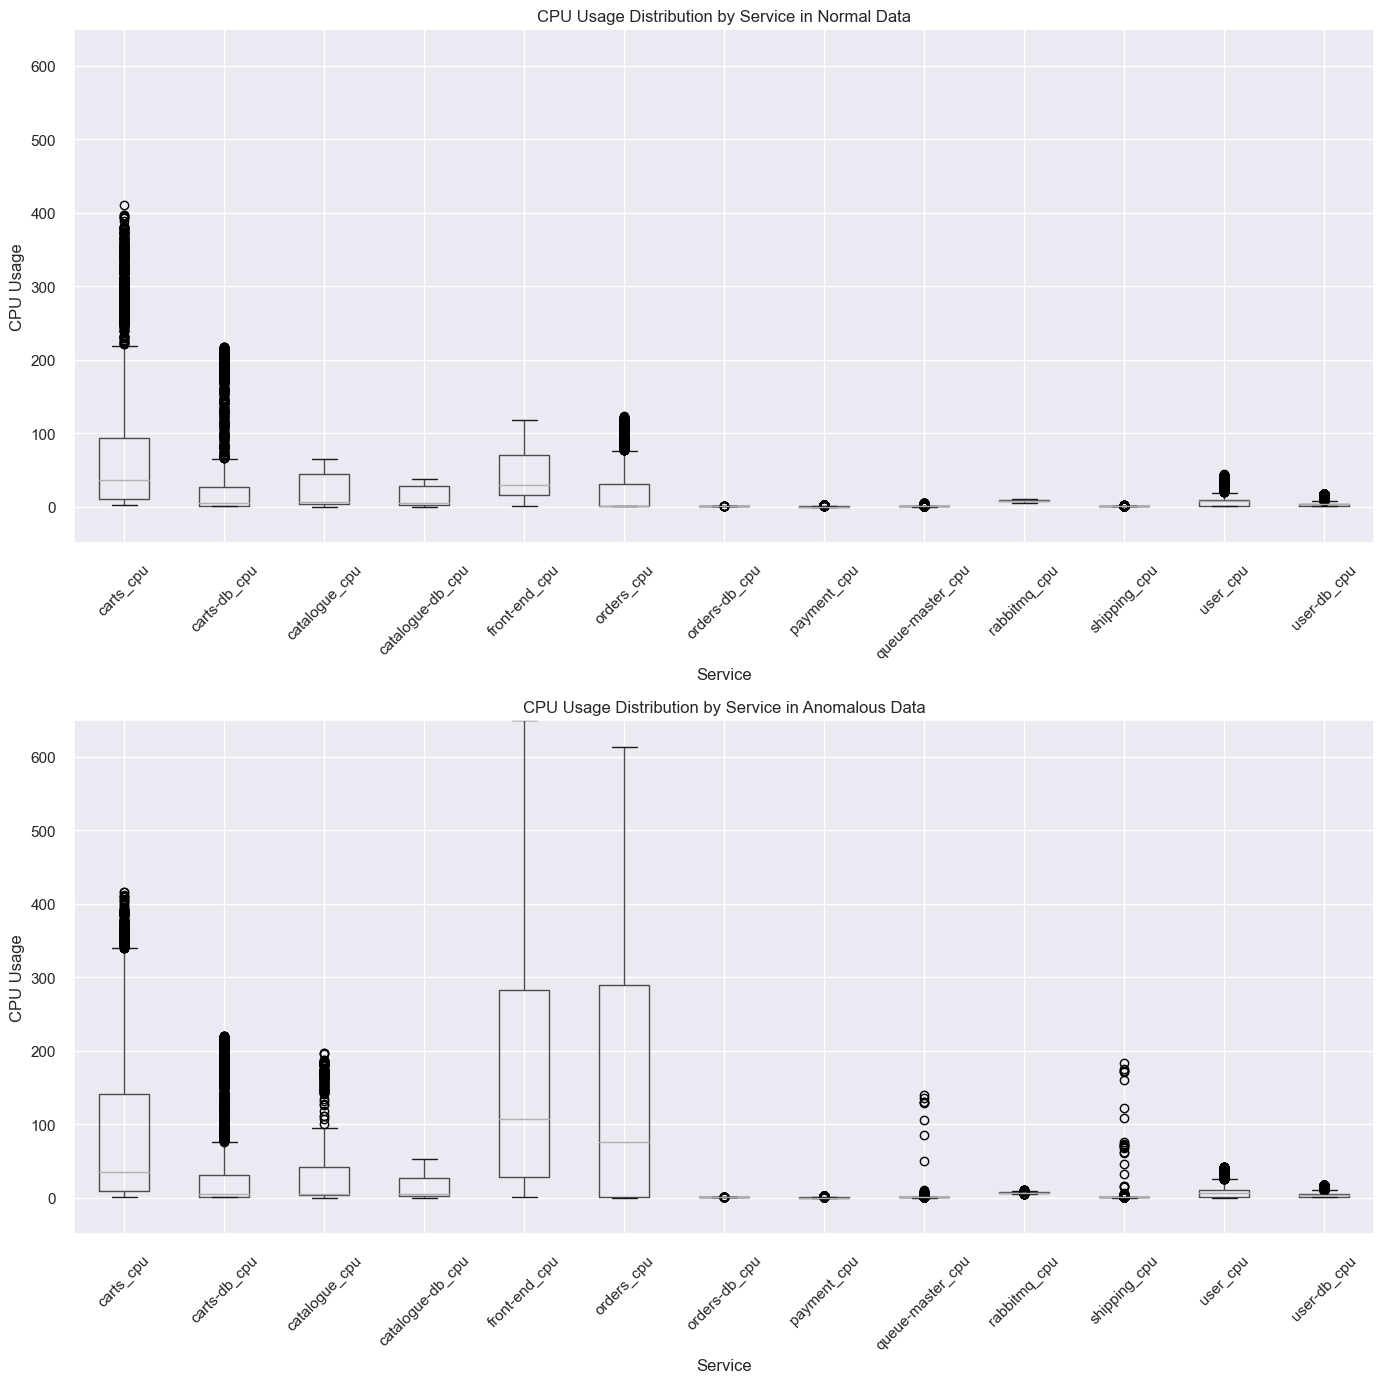

In [78]:
plt.figure(figsize=(14, 14))

plt.subplot(2, 1, 1)
normal_data[cpu_columns].boxplot(rot=45)
# plt.title('Energy Usage Distribution by Service in Normal Data')
plt.title('CPU Usage Distribution by Service in Normal Data')
plt.xlabel('Service')
# plt.ylabel('Energy Usage (J)')
plt.ylabel('CPU Usage')
plt.ylim(-50, max_cpu_value)
plt.grid(True)

plt.subplot(2, 1, 2)
anomalous_data[cpu_columns].boxplot(rot=45)
# plt.title('Energy Usage Distribution by Service in Anomalous Data')
plt.title('CPU Usage Distribution by Service in Anomalous Data')
plt.xlabel('Service')
# plt.ylabel('Energy Usage (J)')
plt.ylabel('CPU Usage')
plt.ylim(-50, max_cpu_value)
plt.grid(True)

plt.tight_layout()
plt.show()


In [20]:
low_user_load_a = anomalous_data[(anomalous_data['users'] == "100")]
melted_low_a = low_user_load_a.melt(id_vars='time', value_vars=energy_columns, var_name='service', value_name='energy_usage')
high_user_load_a = anomalous_data[(anomalous_data['users'] == "1000")]
melted_high_a = high_user_load_a.melt(id_vars='time', value_vars=energy_columns, var_name='service', value_name='energy_usage')

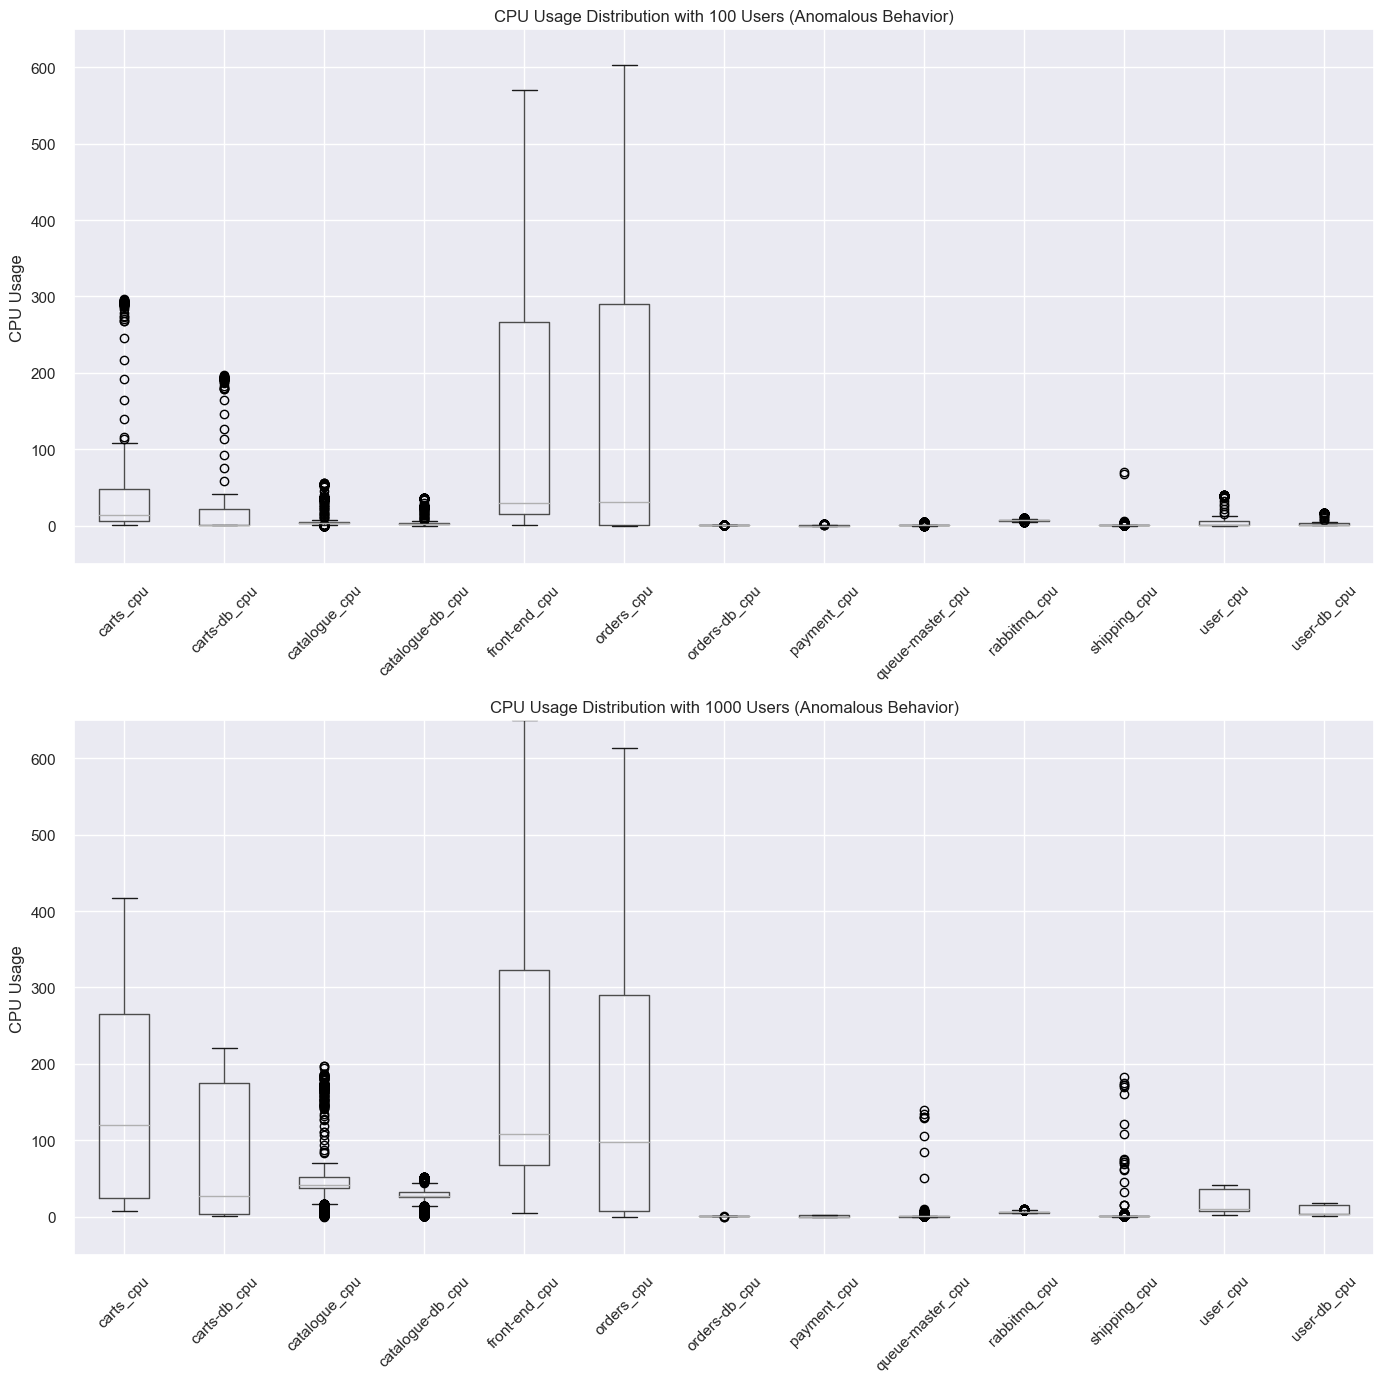

In [79]:
plt.figure(figsize=(14, 14))

plt.subplot(2, 1, 1)
# sns.lineplot(x='time', y='energy_usage', hue='service', data=melted_low_a, palette='tab20')
low_user_load_a[cpu_columns].boxplot(rot=45)
# plt.title('Energy Usage Distribution with 100 Users (Anomalous Behavior)')
plt.title('CPU Usage Distribution with 100 Users (Anomalous Behavior)')
# plt.xlabel('Service')
# plt.ylabel('Energy Usage (J)')
plt.ylabel('CPU Usage')
plt.xticks(rotation=45)
plt.ylim(-50, max_cpu_value)
# plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True)

plt.subplot(2, 1, 2)
# sns.lineplot(x='time', y='energy_usage', hue='service', data=melted_high_a, palette='tab20')
high_user_load_a[cpu_columns].boxplot(rot=45)
# plt.title('Energy Usage Distribution with 1000 Users (Anomalous Behavior)')
plt.title('CPU Usage Distribution with 1000 Users (Anomalous Behavior)')
# plt.xlabel('Service')
# plt.ylabel('Energy Usage (J)')
plt.ylabel('CPU Usage')
plt.xticks(rotation=45)
plt.ylim(-50, max_cpu_value)
# plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True)


plt.tight_layout()
plt.show()

In [22]:
stressed_scenario_a = anomalous_data[(anomalous_data['scenario'] == "scenario_A")]
stressed_melted_a = stressed_scenario_a.melt(id_vars='time', value_vars=energy_columns, var_name='service', value_name='energy_usage')
stressed_scenario_b = anomalous_data[(anomalous_data['scenario'] == "scenario_B")]
stressed_melted_b = stressed_scenario_b.melt(id_vars='time', value_vars=energy_columns, var_name='service', value_name='energy_usage')

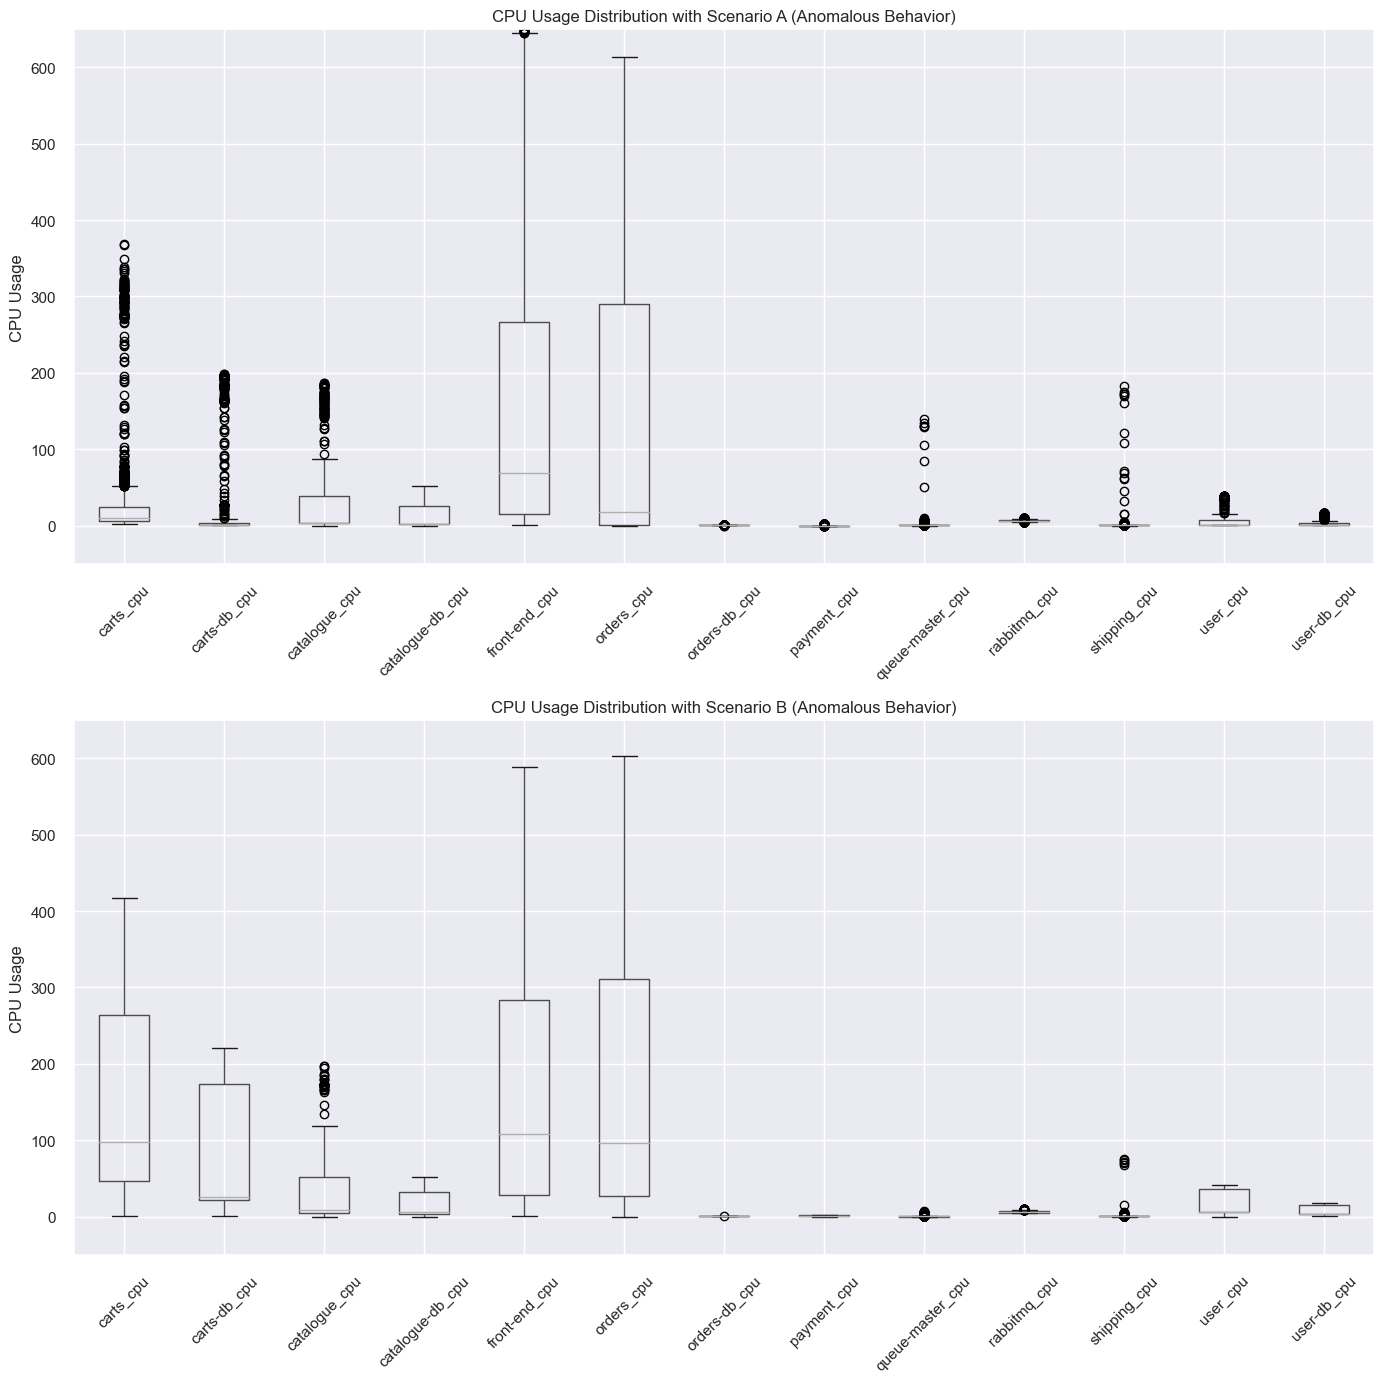

In [80]:
plt.figure(figsize=(14, 14))

plt.subplot(2, 1, 1)
# sns.lineplot(x='time', y='energy_usage', hue='service', data=stressed_melted_a, palette='tab20')
stressed_scenario_a[cpu_columns].boxplot(rot=45)
# plt.title('Energy Usage Distribution with Scenario A (Anomalous Behavior)')
plt.title('CPU Usage Distribution with Scenario A (Anomalous Behavior)')
# plt.xlabel('Service')
# plt.ylabel('Energy Usage (J)')
plt.ylabel('CPU Usage')
plt.xticks(rotation=45)
plt.ylim(-50, max_cpu_value)
# plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True)

plt.subplot(2, 1, 2)
# sns.lineplot(x='time', y='energy_usage', hue='service', data=stressed_melted_b, palette='tab20')
stressed_scenario_b[cpu_columns].boxplot(rot=45)
# plt.title('Energy Usage Distribution with Scenario B (Anomalous Behavior)')
plt.title('CPU Usage Distribution with Scenario B (Anomalous Behavior)')
# plt.xlabel('Service')
# plt.ylabel('Energy Usage (J)')
plt.ylabel('CPU Usage')
plt.xticks(rotation=45)
plt.ylim(-50, max_cpu_value)
# plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True)


plt.tight_layout()
plt.show()

In [24]:
front_end = anomalous_data[(anomalous_data['service'] == "front-end")]
stressed_melted_front = front_end.melt(id_vars='time', value_vars=energy_columns, var_name='service', value_name='energy_usage')
orders = anomalous_data[(anomalous_data['service'] == "orders")]
stressed_melted_orders = orders.melt(id_vars='time', value_vars=energy_columns, var_name='service', value_name='energy_usage')

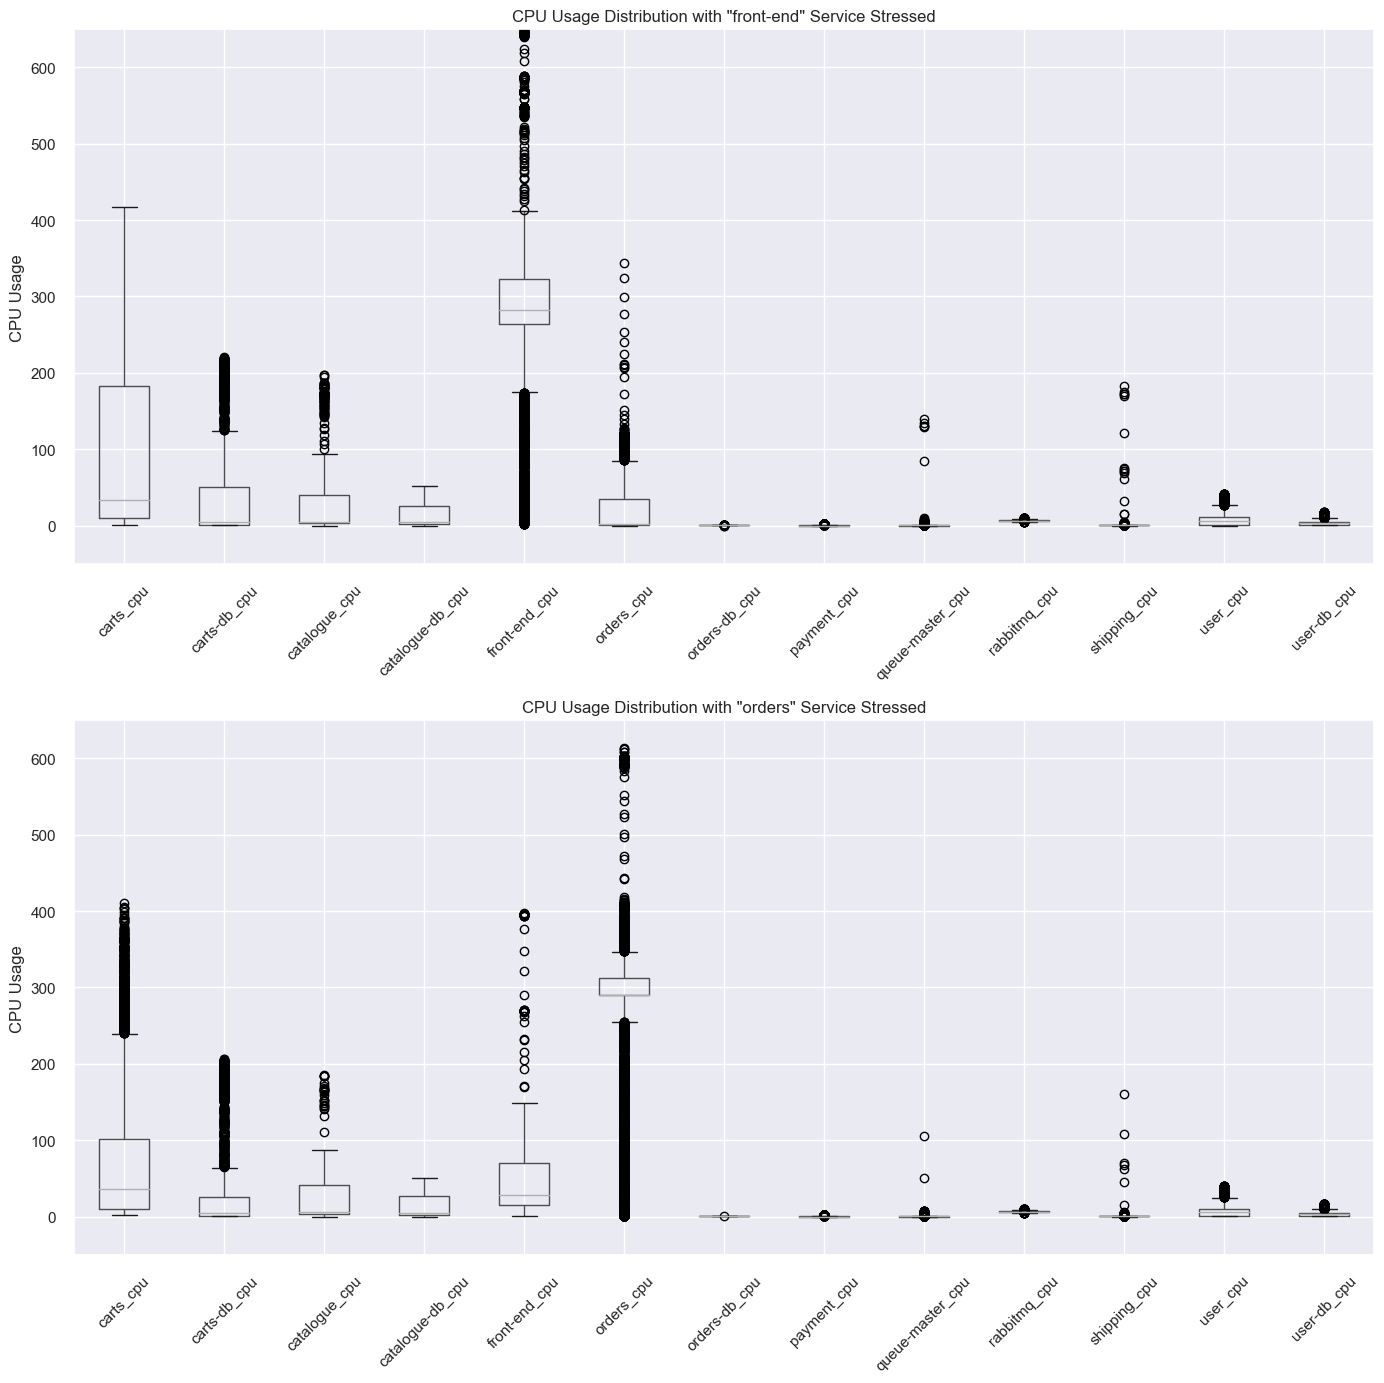

In [81]:
plt.figure(figsize=(14, 14))

plt.subplot(2, 1, 1)
# sns.lineplot(x='time', y='energy_usage', hue='service', data=stressed_melted_front, palette='tab20')
front_end[cpu_columns].boxplot(rot=45)
# plt.title('Energy Usage Distribution with "front-end" Service Stressed')
plt.title('CPU Usage Distribution with "front-end" Service Stressed')
# plt.xlabel('Service')
plt.ylabel('Energy Usage (J)')
plt.ylabel('CPU Usage')
plt.xticks(rotation=45)
plt.ylim(-50, max_cpu_value)
# plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True)

plt.subplot(2, 1, 2)
# sns.lineplot(x='time', y='energy_usage', hue='service', data=stressed_melted_orders, palette='tab20')
orders[cpu_columns].boxplot(rot=45)
# plt.title('Energy Usage Distribution with "orders" Service Stressed')
plt.title('CPU Usage Distribution with "orders" Service Stressed')
# plt.xlabel('Service')
# plt.ylabel('Energy Usage (J)')
plt.ylabel('CPU Usage')
plt.xticks(rotation=45)
plt.ylim(-50, max_cpu_value)
# plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True)


plt.tight_layout()
plt.show()

In [82]:
def train_pycaret_AD_models(train_df, user, scenario):
    os.makedirs("anomaly_detection_models", exist_ok=True)

    train_df.replace(0, np.nan, inplace=True)
    
    # For each type of AD model to be used, create and train a model instance on the normal data
    for model in AD_MODELS:
        for column in train_df.columns:
            if "time" in column or "_energy" not in column:
                continue 
            print("Training anomaly detection models on normal data...")
            print(f"Training {model} model for {scenario}-{user} factors...")
            
            # Train model on Time & Energy dataframe
            col_data = train_df.loc[:, ["time", column]]
            setup(col_data, session_id = 123)
            
            # Train the model
            trained_model = create_model(model)
            
            resource_dir = os.path.join("anomaly_detection_models", SYSTEM, f'{scenario}_{user}_{column}')
            os.makedirs(resource_dir, exist_ok=True)
            
            # Save the model
            save_model(
                trained_model,
                f"{resource_dir}/{model}_pipeline",
            )

In [ ]:
scenarios = normal_data['scenario'].unique()
users = normal_data['users'].unique()

# Dictionary to hold filtered dataframes
filtered_data_dict = {}

# Loop through each combination and filter the data
# for scenario in scenarios:
#     for user in users:
#         combination_key = f"{scenario}_{user}"
#         filtered_data_dict[combination_key] = normal_data[(normal_data['scenario'] == scenario) & (normal_data['users'] == user)]
#         train_pycaret_AD_models(filtered_data_dict[combination_key], user, scenario)



In [65]:
def is_anomaly(value, mean, std, z_score_threshold=2):
    return abs(value - mean) > (z_score_threshold *std)

def create_ground_truth() -> None:
    """
    Indicates which of the data in each collected <metrics>.csv file are considered an anomaly
    based on the threshold value.
    """
    mean_values = normal_data.mean(numeric_only=True)
    std_values = normal_data.std(numeric_only=True)
    
    anomaly_df = anomalous_data.copy()
    
    for column in mean_values.index:
        anomaly_column = f"{column}_Anomaly"
        anomaly_df[anomaly_column] = anomalous_data[column].apply(
            lambda x: 1 if is_anomaly(x, mean_values[column], std_values[column]) else 0
        )
    
    anomaly_df.to_csv('ground_truth.csv', index=False)
    return anomaly_df
            
 

In [66]:
ground_truth = create_ground_truth()

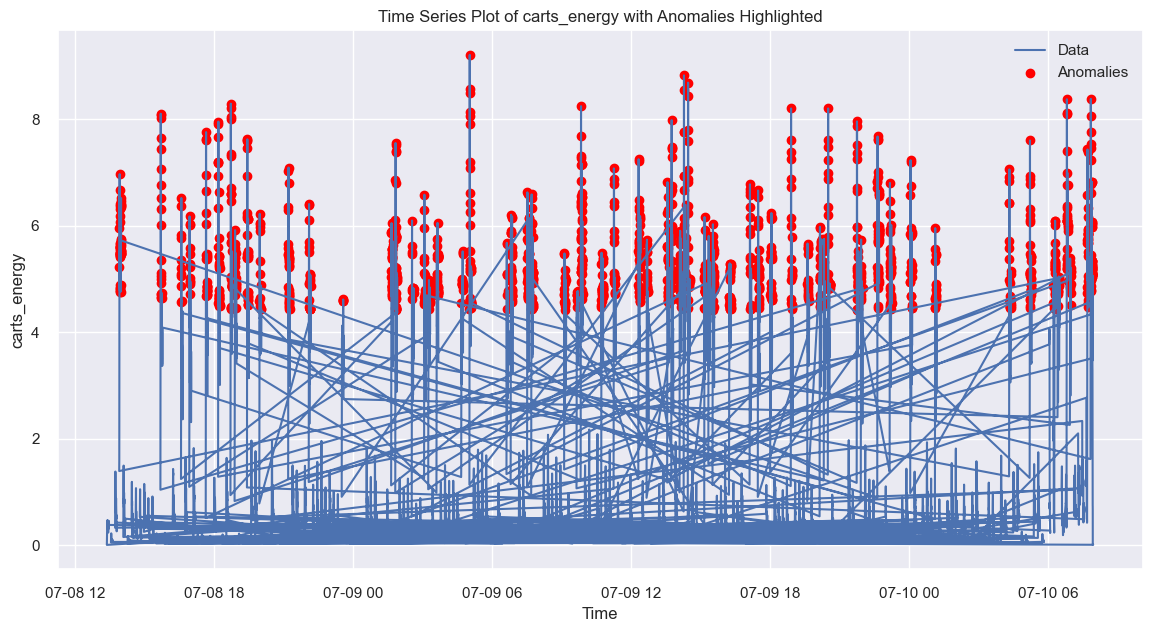

In [67]:
column_to_plot = 'carts_energy'  # Replace with the actual column name
anomaly_column = f"{column_to_plot}_Anomaly"

# Plot the time series data
plt.figure(figsize=(14, 7))
plt.plot(ground_truth['time'], ground_truth[column_to_plot], label='Data')

# Highlight anomalies
anomalies = ground_truth[ground_truth[anomaly_column] == 1]
plt.scatter(anomalies['time'], anomalies[column_to_plot], color='red', label='Anomalies')

plt.xlabel('Time')
plt.ylabel(column_to_plot)
plt.title(f'Time Series Plot of {column_to_plot} with Anomalies Highlighted')
plt.legend()
plt.show()

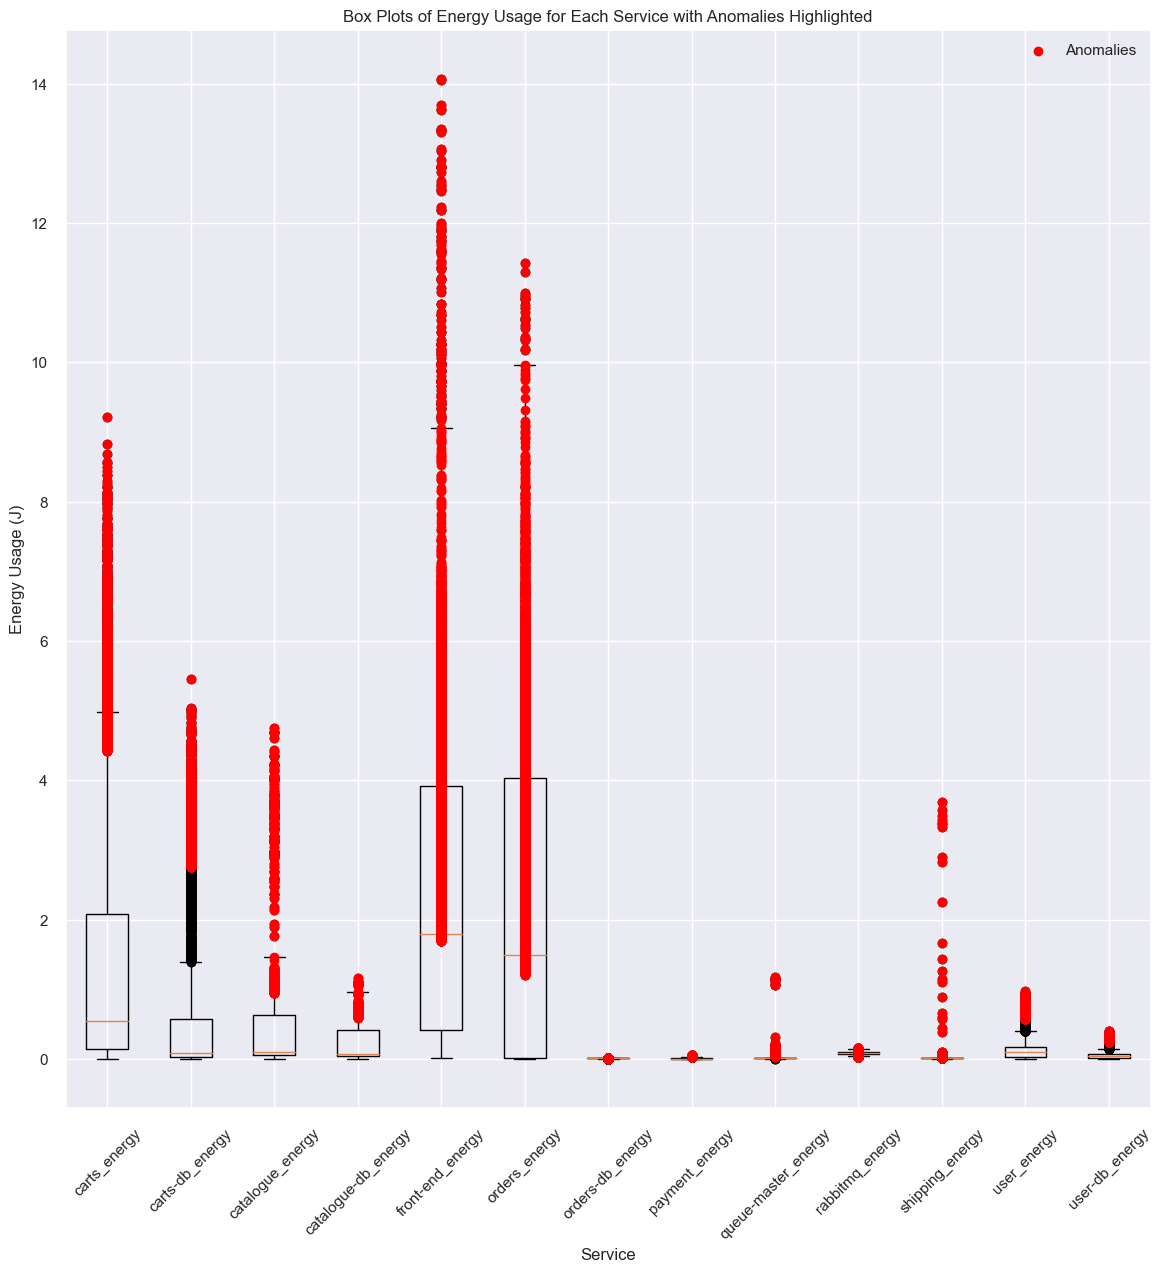

In [68]:
anomaly_columns = [f"{col}_Anomaly" for col in energy_columns]
data_to_plot = [ground_truth[col] for col in energy_columns]

plt.figure(figsize=(14, 14))
plt.boxplot(data_to_plot, labels=energy_columns)

for i, column in enumerate(energy_columns):
    anomaly_column = f"{column}_Anomaly"
    anomalies = ground_truth[ground_truth[anomaly_column] == 1]
    plt.scatter([i + 1] * len(anomalies), anomalies[column], color='red', label='Anomalies' if i == 0 else "", zorder=10)

# Set labels and title
plt.xlabel('Service')
plt.ylabel('Energy Usage (J)')
plt.title('Box Plots of Energy Usage for Each Service with Anomalies Highlighted')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [86]:
class AlgorithmProfiler:
    def __init__(self, algorithm):
        self.algorithm = algorithm
        self.start_time = None
        self.end_time = None
        self.cpu_usage = []
        self.memory_usage = []

    def _monitor_resources(self):
        process = psutil.Process()
        self.cpu_usage.append(process.cpu_percent(interval=1))
        self.memory_usage.append(process.memory_info().rss / (1024 ** 2))  # Memory in MB

    def run(self, *args, **kwargs):
        self.start_time = datetime.now()
        print(f"Starting algorithm at {self.start_time}")

        try:
            while True:
                self._monitor_resources()
                result = self.algorithm(*args, **kwargs)
                break  # Exit after the algorithm is done
        finally:
            self.end_time = datetime.now()
            print(f"Algorithm completed at {self.end_time}")

            avg_cpu_usage = sum(self.cpu_usage) / len(self.cpu_usage)
            avg_memory_usage = sum(self.memory_usage) / len(self.memory_usage)

            print(f"Average CPU Usage: {avg_cpu_usage:.2f}%")
            print(f"Average Memory Usage: {avg_memory_usage:.2f} MB")
            print(f"Total Execution Time: {self.end_time - self.start_time}")

        return result, {
            "start_time": self.start_time,
            "end_time": self.end_time,
            "avg_cpu_usage": avg_cpu_usage,
            "avg_memory_usage": avg_memory_usage,
            "execution_time": self.end_time - self.start_time
        }

In [87]:
def run_BIRCH_AD_with_smoothing(temp_df, df, column):    
    ad_threshold = 0.045  
    smoothing_window = 12
    test_df = df.loc[:, ["time", column]].copy()            

    for svc, energy in test_df.items():
        if svc != 'time':
            energy = energy.rolling(window=smoothing_window, min_periods=1).mean()
            x = np.array(energy)
            x = np.where(np.isnan(x), 0, x)
            normalized_x = preprocessing.normalize([x])

            X = normalized_x.reshape(-1,1)

            birch = Birch(branching_factor=50, n_clusters=None, threshold=ad_threshold, compute_labels=True)
            birch.fit(X)
            birch.predict(X)

            # Calculate distances to cluster centers
            distances = distance.cdist(X, birch.subcluster_centers_)
            min_distances = np.min(distances, axis=1)

            # Set threshold to identify anomalies
            threshold = np.percentile(min_distances, 95)

            # Assign anomaly labels
            test_df['anomaly_label'] = np.where(min_distances > threshold, 1, 0)
            
            temp_df = temp_df.assign(
                **{
                    f"{column}_Anomaly": test_df['anomaly_label'],
                    f"{column}_Anomaly_Score": min_distances,
                }
            )   
    return temp_df

def execute_AD_models():
    unique_combinations = anomalous_data[['scenario', 'service', 'users']].drop_duplicates()

    for _, row in unique_combinations.iterrows():
            scenario = row['scenario']
            service_stressed = row['service']
            users = row['users']

            # Filter the DataFrame for the current combination
            temp_df = anomalous_data[(anomalous_data['scenario'] == scenario) & (anomalous_data['service'] == service_stressed) & (anomalous_data['users'] == users)].copy()

            for column in temp_df.columns:
                if "time" in column or "_energy" not in column:
                    continue

                # Run BIRCH algorithm (placeholder for actual implementation)
                profiler = AlgorithmProfiler(run_BIRCH_AD_with_smoothing)
                birch_results, birch_metrics = profiler.run(temp_df, temp_df, column)
                # birch_results = run_BIRCH_AD_with_smoothing(temp_df, anomalous_data, column)
                model_result_path = os.path.join("birch", f'birch_results_{scenario}_{service_stressed}_{users}_{column}.csv')
                birch_results.to_csv(model_result_path, index=False)
                
                birch_metrics_df = pd.DataFrame([birch_metrics])
                model_metrics_path = os.path.join("birch", f'birch_metrics_{scenario}_{service_stressed}_{users}_{column}.csv')
                birch_metrics_df.to_csv(model_metrics_path, index=False)
                print("BIRCH metrics:", birch_metrics)

                # Run the previously trained algorithms
                train_model_column = f'{scenario}_{users}_{column}'
                model_folder_path = os.path.join("anomaly_detection_models", SYSTEM, train_model_column)
                for ad_model in os.listdir(model_folder_path):
                    print(f"Executing for {scenario}, {service_stressed}, {users}, {ad_model}, {column}, Train Model = {train_model_column}")

                    # Run SVM, KNN, LOF, and iForest algorithms
                    setup(temp_df, session_id = 123, verbose = False)
                    model_path = os.path.join(model_folder_path, f"{ad_model.split('_')[0]}_pipeline")
                    trained_model = load_model(model_path, verbose = False)
                    col_df = temp_df.loc[:, ["time", column]]
                    
                    col_df.replace(0, np.nan, inplace=True)
                    col_df["time"] = pd.to_datetime(col_df["time"], unit="s")
                    profiler = AlgorithmProfiler(predict_model)
                    anomaly_results, ad_metrics = profiler.run(trained_model, data=col_df)
                    # anomaly_results = predict_model(trained_model, data = col_df)
                    
                    temp_df = temp_df.assign(
                        **{
                            f"{column}_Anomaly": anomaly_results["Anomaly"],
                            f"{column}_Anomaly_Score": anomaly_results["Anomaly_Score"],
                        }
                    )   
                    model_result_path = f'{ad_model.split("_")[0]}_results_{scenario}_{service_stressed}_{users}_{column}.csv'
                    temp_df.to_csv(model_result_path, index=False)
                    
                    ad_metrics_df = pd.DataFrame([ad_metrics])
                    model_metrics_path = f'{ad_model.split("_")[0]}_metrics_{scenario}_{service_stressed}_{users}_{column}.csv'
                    ad_metrics_df.to_csv(model_metrics_path, index=False)
                    print(f"{ad_model.split('_')[0]} metrics:", ad_metrics)


In [88]:
result = execute_AD_models()

Starting algorithm at 2024-08-13 12:48:40.424943
Algorithm completed at 2024-08-13 12:48:41.461128
Average CPU Usage: 0.00%
Average Memory Usage: 497.06 MB
Total Execution Time: 0:00:01.036185
BIRCH metrics: {'start_time': datetime.datetime(2024, 8, 13, 12, 48, 40, 424943), 'end_time': datetime.datetime(2024, 8, 13, 12, 48, 41, 461128), 'avg_cpu_usage': 0.0, 'avg_memory_usage': 497.0625, 'execution_time': datetime.timedelta(seconds=1, microseconds=36185)}
Executing for scenario_A, front-end, 100, iforest_pipeline.pkl, carts_energy, Train Model = scenario_A_100_carts_energy
Starting algorithm at 2024-08-13 12:48:44.586727
Algorithm completed at 2024-08-13 12:48:45.697317
Average CPU Usage: 0.00%
Average Memory Usage: 522.52 MB
Total Execution Time: 0:00:01.110590
iforest metrics: {'start_time': datetime.datetime(2024, 8, 13, 12, 48, 44, 586727), 'end_time': datetime.datetime(2024, 8, 13, 12, 48, 45, 697317), 'avg_cpu_usage': 0.0, 'avg_memory_usage': 522.51953125, 'execution_time': datet

KeyboardInterrupt: 